## Notebook to test TherAPPy

The objective of this notebook is to show the functionality of TherAPPy

Note that the code is being developed and the structure and fucntionality of the code will change and improve. Get in touch with the developers if you feel that anything could be improved in particular. 

The code currently includes:

- the Dodson (1973) cooling age model for a range of thermochronometers
- The Ketcham (1999, 2007) apatite fission track annealing model



In [1]:
from importlib import reload
import itertools
import numpy as np
import matplotlib.pyplot as pl
import matplotlib.colors
import astropy.units as u

import lib.therappy_lib as trp

## Set up a temperature history

The temperature history is stored in a python dictionary that contains two numpy arrays, one for time bp and one for temperature.
Note that the unit for time used in TherAPPy is years bp, and the unit for temperature is degrees C. TherAPPy uses the [astropy units](https://docs.astropy.org/en/stable/units/index.html) module to assign physical units to variables. 

In [2]:
time = np.arange(0, 100.0, 1.0)[::-1] * 1e6 * u.year
temperature =  np.linspace(300, 10, 100)  * u.deg_C
tT = {"time": time, "temperature": temperature}

print(f"Temperature history:\n{tT}")

Temperature history:
{'time': <Quantity [99000000., 98000000., 97000000., 96000000., 95000000.,
           94000000., 93000000., 92000000., 91000000., 90000000.,
           89000000., 88000000., 87000000., 86000000., 85000000.,
           84000000., 83000000., 82000000., 81000000., 80000000.,
           79000000., 78000000., 77000000., 76000000., 75000000.,
           74000000., 73000000., 72000000., 71000000., 70000000.,
           69000000., 68000000., 67000000., 66000000., 65000000.,
           64000000., 63000000., 62000000., 61000000., 60000000.,
           59000000., 58000000., 57000000., 56000000., 55000000.,
           54000000., 53000000., 52000000., 51000000., 50000000.,
           49000000., 48000000., 47000000., 46000000., 45000000.,
           44000000., 43000000., 42000000., 41000000., 40000000.,
           39000000., 38000000., 37000000., 36000000., 35000000.,
           34000000., 33000000., 32000000., 31000000., 30000000.,
           29000000., 28000000., 27000000., 26

## Model closure ages using the Dodson model

We first model the closure ages following Dodson (1973) for the apatite and zircon (U-Th)/He and fission track thermochronometers, using parameters from Reiners and Brandon (2006, https://doi.org/10.1146/annurev.earth.34.031405.125202)

In [3]:
minerals = ["apatite", "apatite", "zircon", "zircon"]
thermochronometers = ["He", "FT", "He", "FT"]

grains = []
ages = []

# go through the thermochron systems
for mineral, thermochronometer in zip(minerals, thermochronometers):
    
    # create a new thermochron object for each mineral & thermochronometer combination
    mygrain = trp.thermochron_object(mineral)
    
    # model the thermochron age
    model_results = mygrain.model_thermochron(tT, thermochronometer=thermochronometer, model="Dodson")
    
    # store the ages
    ages.append(model_results["modelled_thermochron_age_bp"])
    
    # store the grain in a list
    grains.append(mygrain)
    
    print(f"modelled thermochron age for the system {mygrain.mineral} {thermochronometer} using the {mygrain.model} model: "
          f"{model_results['modelled_thermochron_age_bp']:0.2e}")

modelled thermochron age for the system apatite He using the Dodson model: 9.65e+06 yr
modelled thermochron age for the system apatite FT using the Dodson model: 2.43e+07 yr
modelled thermochron age for the system zircon He using the Dodson model: 4.50e+07 yr
modelled thermochron age for the system zircon FT using the Dodson model: 5.78e+07 yr


## Model AFT using the Ketcham (2007) model

Next we model the apatite fission track age using a implementation of the fission track annealing model described in Ketcham et al. (1999) and Ketcham (2007). The annealing resistance can be specified using the chlorine weight fraction or the Dpar parameter. We assing a chlorine weight fraction of 0.0 below.

In [4]:
# assign fission track annealing parameters
thermochron_parameters = {"kinetic_parameter": "Clwt", "Clwt": 0.0}

# set up a new grain
FTgrain = trp.thermochron_object("apatite")

# model the apatite fission track age
model_results = FTgrain.model_thermochron(tT, thermochronometer="FT", model="Ketcham2007", thermochron_parameters=thermochron_parameters)

modelled_AFT_age = model_results["AFT_age"]

print(f"modelled apatite fission track age: {modelled_AFT_age :0.2f}")

--------------------
No module named 'lib.AFT_model_core'
failed to import fortran annealing module
use slower python implementation of AFT annealing module instead
compile the fortran module by running the following command in the source directory of this module:
f2py -c AFT_model_core.f90 -m AFT_model_core
--------------------
modelled apatite fission track age: 27352858.73 yr yr


/Users/elco/python_scripts/TherAPPy/lib/AFT_model_lib.py:407: RuntimeWarning: invalid value encountered in power
  rc_mod = ((rc - rmr0) / (1.0-rmr0)) ** kappa


## Show T history and modelled ages in a figure

Lets compare the closure ages with the modelled apatite fission track age:

UnitConversionError: Can only apply 'less' function to dimensionless quantities when other argument is not a quantity (unless the latter is all zero/infinity/nan)

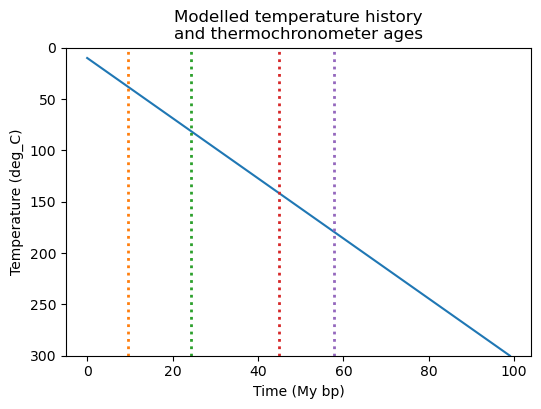

In [5]:
colors = list(matplotlib.colors.TABLEAU_COLORS)

fig, ax = pl.subplots(1, 1, figsize=(6, 4))
ax.plot(tT["time"].value / 1e6, tT["temperature"], label="T history")
ax.set_ylim(tT["temperature"].value.max(), 0)
ax.set_xlabel("Time (My bp)")
Tu = tT["temperature"].unit
ax.set_ylabel(f"Temperature ({Tu})")
ax.set_title("Modelled temperature history\nand thermochronometer ages")

for i, grain, age in zip(itertools.count(), grains, ages):
    mineral = grain.mineral
    thermochronometer = grain.thermochronometer
    ax.axvline(age.value / 1e6, c=colors[i+1], ls=":", lw=2.0, label=f"{mineral} {thermochronometer} age,\n Dodson (1973)")

ax.axvline(modelled_AFT_age.value / 1e6, c=colors[i+2], ls="--", lw=1.5, label="AFT age,\n Ketcham (2007)")
    
ax.legend(bbox_to_anchor=(1, 0.75))

ax.set_xlim(tT["time"].value.max() / 1e6, 0)

fig.tight_layout()

fig.savefig("fig/TherAPPy_example.png")